### Importing the libraries

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

### Preparing the results dataframe

In [2]:
df = pd.read_csv("Results - Sheet1.csv")


df[["Model", "comments", "dataset", "dataset type"]] = df[
    ["Model", "comments", "dataset", "dataset type"]
].fillna(" ")
df[["Precision Performance", "Recall Performance", "F1 performance"]] = df[
    ["Precision Performance", "Recall Performance", "F1 performance"]
].fillna(0)

### Exploring and Extracting the results for adding to the paper.

In [3]:
model = "Prototex"
comments = " "

for attack in [
    "textbugger",
    "textfooler",
    "paraphrased",
]:
    print("Attack: ", attack)
    for dataset in ["imdb", "ag_news", "dbpedia"]:
        sub_df = df[
            (df["Model"] == model)
            & (df["comments"] == comments)
            & (df["dataset"] == dataset)
            & (df["dataset type"].str.endswith(attack))
        ]
        if len(sub_df) != 2:
            raise ValueError("Not 2 rows")
        adv = sub_df[sub_df["dataset type"] == f"adv - {attack}"]
        test = sub_df[sub_df["dataset type"] == f"test - {attack}"]
        print(
            "%.3f" % test["F1 performance"].values[0],
            "&",
            "%.3f" % adv["F1 performance"].values[0],
            "&",
            "%.3f"
            % (
                (adv["F1 performance"].values[0] - test["F1 performance"].values[0])
                / test["F1 performance"].values[0]
            ),
            "&",
        )
    print("------------------")

Attack:  textbugger
0.969 & 0.895 & -0.076 &
0.937 & 0.756 & -0.193 &
0.936 & 0.729 & -0.221 &
------------------
Attack:  textfooler
0.974 & 0.934 & -0.041 &
0.975 & 0.812 & -0.167 &
0.956 & 0.715 & -0.252 &
------------------
Attack:  paraphrased
0.950 & 0.950 & 0.000 &
0.970 & 0.883 & -0.090 &
0.960 & 0.974 & 0.015 &
------------------


### Effect of the separability coefficient on the robustness of the models

/tmp/ipykernel_80896/152651010.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([round(x, 2) for x in ax.get_yticks()], fontsize=8)
/tmp/ipykernel_80896/152651010.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([round(x, 2) for x in ax.get_yticks()], fontsize=8)
/tmp/ipykernel_80896/152651010.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([round(x, 2) for x in ax.get_yticks()], fontsize=8)
/tmp/ipykernel_80896/152651010.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([round(x, 2) for x in ax.get_yticks()], fontsize=8)


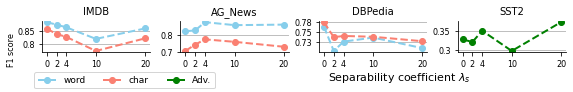

In [46]:
fig, axs = plt.subplots(1, 4, figsize=(8, 1))

for dataset, ax in zip(["IMDB", "AG_News", "DBPedia", "SST2"], axs.flatten()):
    values_textfooler = []
    values_textbugger = []
    values_adv = []
    

    for comment in [
        "separability_0",
        "separability_2",
        "separability_4",
        "separability_10",
        "separability_20",
    ]:
        sub_df = df[
            (df["Model"] == "Prototex")
            & (df["dataset"] == dataset.lower())
            & (df["comments"] == comment)
        ]

        if dataset != "SST2": 
            relative_drop_in_f1_textfooler = sub_df[
                sub_df["dataset type"] == "adv - textfooler"
            ]["F1 performance"].values[0]

            relative_drop_in_f1_textbugger = sub_df[
                sub_df["dataset type"] == "adv - textbugger"
            ]["F1 performance"].values[0]

            values_textfooler.append(relative_drop_in_f1_textfooler)
            values_textbugger.append(relative_drop_in_f1_textbugger)
        else:
            relative_drop_in_f1_adv = sub_df[
                sub_df["dataset type"] == "adv"
            ]["F1 performance"].values[0]
            
            values_adv.append(relative_drop_in_f1_adv)

    if dataset != "SST2":
        ax.plot(
            [0, 2, 4, 10, 20],
            values_textfooler,
            label="word",
            color="skyblue",
            linestyle="dashed",
            marker="o",
            markersize=6,
            linewidth=2,
        )
        ax.plot(
            [0, 2, 4, 10, 20],
            values_textbugger,
            label="char",
            color="salmon",
            linestyle="dashed",
            marker="o",
            markersize=6,
            linewidth=2,
        )
    else:
        ax.plot(
            [0, 2, 4, 10, 20],
            values_adv,
            label="Adv.",
            color="green",
            linestyle="dashed",
            marker="o",
            markersize=6,
            linewidth=2,
        )
    ax.set_title(dataset, fontsize=10)
    ax.grid(axis="y")

    # remove upper and right spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xticks([0, 2, 4, 10, 20])
    # ax.yticks(fontsize=12)
    # this produces error, instead use set_yticks and then fontsize=12, and round the yticks
    ax.set_yticklabels([round(x, 2) for x in ax.get_yticks()], fontsize=8)
    ax.set_xticklabels(ax.get_xticks(), fontsize=8)


# combine the legends from different axes and deduplicate
handles_list, labels_list = [], []
for ax in axs.flatten():
    handles, labels = ax.get_legend_handles_labels()
    handles_list += handles
    labels_list += labels
# deduplicate
handles_list, labels_list = zip(
    *[(h, l) for i, (h, l) in enumerate(zip(handles_list, labels_list)) if l not in labels_list[:i]]
)
fig.legend(handles_list, labels_list, loc=(0.06, 0.04), prop={"size": 9}, ncols=3)
# handles, labels = axs[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc=(0.78, 0.76), prop={"size": 13})

# handles, labels = axs[dataset_index].get_legend_handles_labels()
# fig.legend(handles, labels, loc=(0.78, 0.76), prop={"size": 13})

# Add common x-axis label and y-axis label, and also change the position of the supxlabel a bit to the right
fig.supxlabel("Separability coefficient $\lambda_s$", fontsize=11, x=0.7)
fig.supylabel("F1 score", fontsize=8)


# plt.tight_layout()
plt.subplots_adjust(left=0.08,
                    bottom=0.46, 
                    right=0.99, 
                    top=0.9, 
                    wspace=0.28, 
                    hspace=None)
plt.savefig("figures/effect_of_separability.png", dpi=900)
plt.show()

### Effect of different objective functions on the robustness of the models

/tmp/ipykernel_62994/2043521960.py:139: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[index].set_yticklabels([round(x, 2) for x in axs[index].get_yticks()], fontsize=17)
/tmp/ipykernel_62994/2043521960.py:139: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[index].set_yticklabels([round(x, 2) for x in axs[index].get_yticks()], fontsize=17)
/tmp/ipykernel_62994/2043521960.py:139: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[index].set_yticklabels([round(x, 2) for x in axs[index].get_yticks()], fontsize=17)
/tmp/ipykernel_62994/2043521960.py:139: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[index].set_yticklabels([round(x, 2) for x in axs[ind

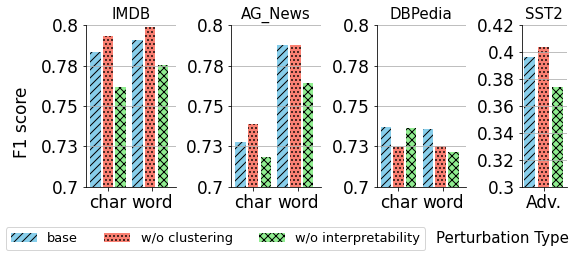

In [11]:
fig, axs = plt.subplots(1, 4, figsize=(8, 3.5), width_ratios=[1, 1, 1, 0.5])
for index, dataset in enumerate(["IMDB", "AG_News", "DBPedia", "SST2"]):
    x = df[
        (df["Model"] == "Prototex")
        & (
            df["comments"].isin(
                ["base", "w/o clustering", "separability_0", "w/o interpretability"]
            )
        )
        & (df["dataset"] == dataset.lower())
        & (~df["dataset type"].str.contains("paraphrased"))
    ]

    model_types = ["base", "w/o clustering", "w/o interpretability"]
    values_base = []
    values_clustering = []
    values_interpretability = []
    if dataset == "SST2":
        x_adv_base = x[
            (x["dataset type"] == f"adv") & (x["comments"] == "base")
        ]["F1 performance"].values[0]
        
        x_adv_clustering = x[
            (x["dataset type"] == f"adv")
            & (x["comments"] == "w/o clustering")
        ]["F1 performance"].values[0]
        
        x_adv_interpretability = x[
            (x["dataset type"] == f"adv")
            & (x["comments"] == "w/o interpretability")
        ]["F1 performance"].values[0]
        
        values_base.append(x_adv_base)
        values_clustering.append(x_adv_clustering)
        values_interpretability.append(x_adv_interpretability)
    else:
        for attack in ["textbugger", "textfooler"]:
            
            x_adv_base = x[
                (x["dataset type"] == f"adv - {attack}") & (x["comments"] == "base")
            ]["F1 performance"].values[0]

           
            x_adv_clustering = x[
                (x["dataset type"] == f"adv - {attack}")
                & (x["comments"] == "w/o clustering")
            ]["F1 performance"].values[0]

            x_test_interpretability = x[
                (x["dataset type"] == f"test - {attack}")
                & (x["comments"] == "w/o interpretability")
            ]["F1 performance"].values[0]
            x_adv_interpretability = x[
                (x["dataset type"] == f"adv - {attack}")
                & (x["comments"] == "w/o interpretability")
            ]["F1 performance"].values[0]

            values_base.append(x_adv_base)
            values_clustering.append(x_adv_clustering)
            values_interpretability.append(x_adv_interpretability)

    width = 0.5
    
    if dataset != "SST2":
        axs[index].bar(
            [0, 2],
            values_base,
            label="base",
            color="skyblue",
            width=width,
            hatch="///",
        )

        axs[index].bar(
            [0.6, 2.6],
            values_clustering,
            label="w/o clustering",
            color="salmon",
            width=width,
            hatch="...",
        )

        axs[index].bar(
            [1.2, 3.2],
            values_interpretability,
            label="w/o interpretability",
            color="lightgreen",
            width=width,
            hatch="xxx",
        )
    else: 
        axs[index].bar(
            [0],
            values_base,
            label="base",
            color="skyblue",
            width=width,
            hatch="///",
        )

        axs[index].bar(
            [0.6],
            values_clustering,
            label="w/o clustering",
            color="salmon",
            width=width,
            hatch="...",
        )

        axs[index].bar(
            [1.2],
            values_interpretability,
            label="w/o interpretability",
            color="lightgreen",
            width=width,
            hatch="xxx",
        )

    # draw the xtick labels in the next line
    if dataset != "SST2":
        axs[index].set_xticks([0.6, 2.7])
        axs[index].set_xlim([None, 3.8])
        axs[index].set_ylim([0.7, 0.9])
    else: 
        axs[index].set_xticks([0.6])
        axs[index].set_xlim([None, 1.6])
        axs[index].set_ylim([0.3, 0.42])
    axs[index].set_title(dataset, fontsize=15)
    # axs[index].set(xlabel="Component removed", ylabel="F1 score change")
    # if dataset != "SST2":
    #     axs[index].set_ylim([0.7, 0.9])
    # else:
    #     axs[index].set_ylim([0.2, 0.45])
    # remove the upper and right spines
    axs[index].spines["right"].set_visible(False)
    axs[index].spines["top"].set_visible(False)
    axs[index].grid(axis="y")
    
    axs[index].set_yticklabels([round(x, 2) for x in axs[index].get_yticks()], fontsize=17)
    axs[index].set_xticklabels(axs[index].get_xticks(), fontsize=17)
    
    if dataset != "SST2":
        axs[index].set_xticklabels(["char", "word"])
    else:
        axs[index].set_xticklabels(["Adv."])
handles, labels = axs[index].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.01, 0.01), prop={"size": 13}, ncols=3)
fig.supxlabel("Perturbation Type", fontsize=15, x=0.87)
fig.supylabel("F1 score", fontsize=17)
plt.tight_layout()
plt.savefig("figures/effect_of_diff_components.png", dpi=900)
plt.show()

### Effect of Scaling up the backbone on PBN's robustness

/tmp/ipykernel_62994/1212592266.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[index].set_yticklabels([round(x, 2) for x in axs[index].get_yticks()], fontsize=17)
/tmp/ipykernel_62994/1212592266.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[index].set_yticklabels([round(x, 2) for x in axs[index].get_yticks()], fontsize=17)
/tmp/ipykernel_62994/1212592266.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[index].set_yticklabels([round(x, 2) for x in axs[index].get_yticks()], fontsize=17)
/tmp/ipykernel_62994/1212592266.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[index].set_yticklabels([round(x, 2) for x in axs[index].

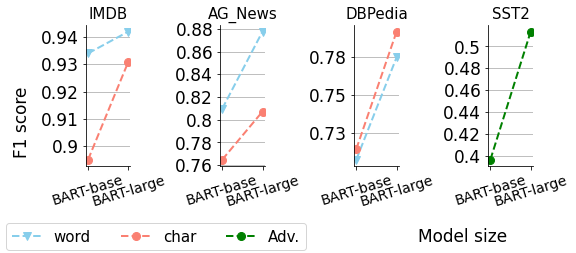

In [6]:
fig, axs = plt.subplots(1, 4, figsize=(8, 3.5), sharex=True, width_ratios=[1, 1, 1, 1])
for index1, model in enumerate(["Prototex"]):
    for index, dataset in enumerate(["IMDB", "AG_News", "DBPedia", "SST2"]):
        x = df[
            (df["comments"].isin(["larger model", " ", "base"]))
            & (df["dataset"] == dataset.lower())
            & (df["Model"] == model)
        ]
        if dataset != "SST2":
            x_adv_textfooler = x[x["dataset type"] == f"adv - textfooler"]
            x_adv_textbugger = x[x["dataset type"] == f"adv - textbugger"]

            axs[index].plot(
                [0, 0.5],
                [
                    x_adv_textfooler[x_adv_textfooler["comments"] == " "][
                        "F1 performance"
                    ].values[0],
                    x_adv_textfooler[x_adv_textfooler["comments"] == "larger model"][
                        "F1 performance"
                    ].values[0],
                ],
                label="word",
                color="skyblue",
                marker="v",
                markersize=8,
                linewidth=2,
                linestyle="dashed",
            )
            axs[index].plot(
                [0, 0.5],
                [
                    x_adv_textbugger[x_adv_textbugger["comments"] == " "][
                        "F1 performance"
                    ].values[0],
                    x_adv_textbugger[x_adv_textbugger["comments"] == "larger model"][
                        "F1 performance"
                    ].values[0],
                ],
                label="char",
                color="salmon",
                marker="o",
                markersize=8,
                linewidth=2,
                linestyle="dashed",
            )
        else: 
            x_adv = x[x["dataset type"] == f"adv"]
            axs[index].plot(
                [0, 0.5],
                [
                    x_adv[x_adv["comments"] == "base"][
                        "F1 performance"
                    ].values[0],
                    x_adv[x_adv["comments"] == "larger model"][
                        "F1 performance"
                    ].values[0],
                ],
                label="Adv.",
                color="green",
                marker="o",
                markersize=8,
                linewidth=2,
                linestyle="dashed",
            )

        axs[index].grid(axis="y")
        axs[index].set_title(dataset, fontsize=15)
        # write down the x label ticks
        axs[index].set_xticks([0, 0.5], ["BART-base", "BART-large"], fontsize=14, rotation=17)
        # remove the upper and right spines
        axs[index].spines["right"].set_visible(False)
        axs[index].spines["top"].set_visible(False)
        
        axs[index].set_yticklabels([round(x, 2) for x in axs[index].get_yticks()], fontsize=17)
        # axs[index].set_xticklabels(axs[index].get_xticks(), fontsize=12)

handles_list, labels_list = [], []
for ax in axs:
    handles, labels = ax.get_legend_handles_labels()
    handles_list += handles
    labels_list += labels
# deduplicate
handles_list, labels_list = zip(
    *[(h, l) for i, (h, l) in enumerate(zip(handles_list, labels_list)) if l not in labels_list[:i]]
)
fig.legend(handles_list, labels_list, loc=(0.01, 0.01), prop={"size": 15}, ncol=3)
fig.supxlabel("Model size", fontsize=17, x=0.80)
fig.supylabel("F1 score", fontsize=17)
plt.tight_layout()
plt.savefig("figures/effect_of_size.png", dpi=900)
plt.show()

## Effect of Number of Prototypes on Robustness

[0.45, 0.467]
[0.735, 0.811]
[0.555, 0.548]
[0.394]


/tmp/ipykernel_62994/3805196638.py:152: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[index].set_yticklabels([round(x, 2) for x in axs[index].get_yticks()], fontsize=17)
/tmp/ipykernel_62994/3805196638.py:152: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[index].set_yticklabels([round(x, 2) for x in axs[index].get_yticks()], fontsize=17)
/tmp/ipykernel_62994/3805196638.py:152: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[index].set_yticklabels([round(x, 2) for x in axs[index].get_yticks()], fontsize=17)
/tmp/ipykernel_62994/3805196638.py:152: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[index].set_yticklabels([round(x, 2) for x in axs[ind

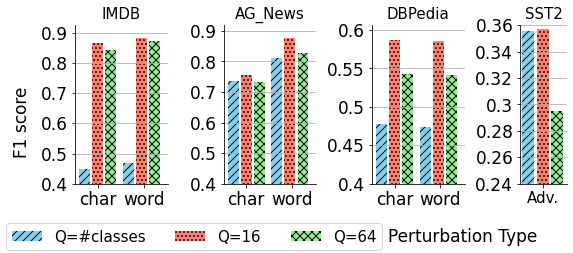

In [10]:
fig, axs = plt.subplots(1, 4, figsize=(8, 3.5), width_ratios=[1, 1, 1, 0.5])
for index, dataset in enumerate(["IMDB", "AG_News", "DBPedia", "SST2"]):
    if dataset.lower() in ["imdb", "sst2"]:
        x = df[
            (df["Model"] == "Prototex")
            & (df["comments"].isin(["DP=2", "base", "DP=64"]))
            & (df["dataset"] == dataset.lower())
            & (~df["dataset type"].str.contains("paraphrased"))
        ]
        model_types = ["DP=2", "base", "DP=64"]

    elif dataset.lower() == "ag_news":
        x = df[
            (df["Model"] == "Prototex")
            & (df["comments"].isin(["DP=4", "base", "DP=64"]))
            & (df["dataset"] == dataset.lower())
            & (~df["dataset type"].str.contains("paraphrased"))
        ]
        model_types = ["DP=4", "base", "DP=64"]
    else:
        x = df[
            (df["Model"] == "Prototex")
            & (df["comments"].isin(["DP=9", "base", "DP=64"]))
            & (df["dataset"] == dataset.lower())
            & (~df["dataset type"].str.contains("paraphrased"))
        ]
        model_types = ["DP=9", "base", "DP=64"]

    mapper = {"imdb": "DP=2", "ag_news": "DP=4", "dbpedia": "DP=9", "sst2": "DP=2"}
    values_base = []
    values_clustering = []
    values_interpretability = []
    if dataset == "SST2":
        x_adv_base = x[
            (x["dataset type"] == f"adv") & (x["comments"] == mapper[dataset.lower()])
        ]["F1 performance"].values[0]
        
        x_adv_clustering = x[
            (x["dataset type"] == f"adv") & (x["comments"] == "base")
        ]["F1 performance"].values[0]
        
        x_adv_interpretability = x[
            (x["dataset type"] == f"adv") & (x["comments"] == "DP=64")
        ]["F1 performance"].values[0]
        
        values_base.append(x_adv_base)
        values_clustering.append(x_adv_clustering)
        values_interpretability.append(x_adv_interpretability)
    else:
            
        for attack in ["textbugger", "textfooler"]:
            
            x_adv_base = x[
                (x["dataset type"] == f"adv - {attack}")
                & (x["comments"] == mapper[dataset.lower()])
            ]["F1 performance"].values[0]

            
            x_adv_clustering = x[
                (x["dataset type"] == f"adv - {attack}") & (x["comments"] == "base")
            ]["F1 performance"].values[0]

            
            x_adv_interpretability = x[
                (x["dataset type"] == f"adv - {attack}") & (x["comments"] == "DP=64")
            ]["F1 performance"].values[0]

            values_base.append(x_adv_base)
            values_clustering.append(x_adv_clustering)
            values_interpretability.append(x_adv_interpretability)

    width = 0.5
    print(values_base)

    if dataset != "SST2":
        axs[index].bar(
            [0, 2],
            values_base,
            label="Q=#classes",
            color="skyblue",
            width=width,
            hatch="///",
        )   

        axs[index].bar(
            [.6, 2.6],
            values_clustering,
            label="Q=16",
            color="salmon",
            width=width,
            hatch="...",
        )
        
        axs[index].bar(
            [1.2, 3.2],
            values_interpretability,
            label="Q=64",
            color="lightgreen",
            width=width,
            hatch="xxx",
        )
    else: 
        axs[index].bar(
            [0],
            values_base,
            label="Q=#classes",
            color="skyblue",
            width=width,
            hatch="///",
        )

        axs[index].bar(
            [0.6],
            values_clustering,
            label="Q=16",
            color="salmon",
            width=width,
            hatch="...",
        )

        axs[index].bar(
            [1.2],
            values_interpretability,
            label="Q=64",
            color="lightgreen",
            width=width,
            hatch="xxx",
        )
    # draw the xtick labels in the next line
    if dataset != "SST2":
        axs[index].set_xticks([0.6, 2.7])
        axs[index].set_xlim([None, 3.8])
        axs[index].set_ylim([0.4, None])
        
    else:
        axs[index].set_xticks([0.6])
        axs[index].set_xlim([None, 1.6])
        axs[index].set_ylim([0.25, 0.40])
    
    # if dataset == "AG_News":
    #     ax.yaxis.tick_right()
    
    axs[index].set_title(dataset, fontsize=15)
    axs[index].spines["right"].set_visible(False)
    axs[index].spines["top"].set_visible(False)
    axs[index].grid(axis="y")
    if dataset != "SST2":
        axs[index].set_xticklabels(["char", "word"], fontsize=17)
    else:
        axs[index].set_xticklabels(["Adv."], fontsize=15)
        
    axs[index].set_yticklabels([round(x, 2) for x in axs[index].get_yticks()], fontsize=17)
    
    # axs[index].set_ylim([0.4, None])
handles, labels = axs[index].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.01, 0.01), prop={"size": 15}, ncol=3)
fig.supxlabel("Perturbation Type", fontsize=17, x=0.80)
fig.supylabel("F1 score", fontsize=17)
plt.tight_layout()
plt.savefig("figures/effect_of_prototypes.png", dpi=900)
plt.show()

## Effect of distance function on Robustness

/tmp/ipykernel_62994/3376268698.py:95: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[index].set_yticklabels([round(x, 2) for x in axs[index].get_yticks()], fontsize=17)
/tmp/ipykernel_62994/3376268698.py:95: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[index].set_yticklabels([round(x, 2) for x in axs[index].get_yticks()], fontsize=17)
/tmp/ipykernel_62994/3376268698.py:95: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[index].set_yticklabels([round(x, 2) for x in axs[index].get_yticks()], fontsize=17)
/tmp/ipykernel_62994/3376268698.py:95: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[index].set_yticklabels([round(x, 2) for x in axs[index].

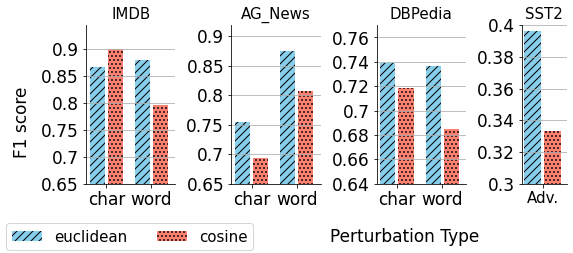

In [9]:
fig, axs = plt.subplots(1, 4, figsize=(8, 3.5), width_ratios=[1, 1, 1, .5])
for index, dataset in enumerate(["IMDB", "AG_News", "DBPedia", "SST2"]):
    x = df[
        (df["Model"] == "Prototex")
        & (df["comments"].isin(["base", "cosine"]))
        & (df["dataset"] == dataset.lower())
        & (~df["dataset type"].str.contains("paraphrased"))
    ]

    model_types = ["base", "cosine"]
    values_base = []
    values_clustering = []
    
    if dataset == "SST2":
        x_adv_base = x[
            (x["dataset type"] == f"adv") & (x["comments"] == "base")
        ]["F1 performance"].values[0]
        
        x_adv_clustering = x[
            (x["dataset type"] == f"adv") & (x["comments"] == "cosine")
        ]["F1 performance"].values[0]
        
        values_base.append(x_adv_base)
        values_clustering.append(x_adv_clustering)
    else: 
        for attack in ["textbugger", "textfooler"]:
            x_adv_base = x[
                (x["dataset type"] == f"adv - {attack}") & (x["comments"] == "base")
            ]["F1 performance"].values[0]
            x_adv_clustering = x[
                (x["dataset type"] == f"adv - {attack}") & (x["comments"] == "cosine")
            ]["F1 performance"].values[0]
            values_base.append(x_adv_base)
            values_clustering.append(x_adv_clustering)
            
    width = 0.5
    
    if dataset != "SST2":
        axs[index].bar(
            [0, 1.5],
            values_base,
            label="euclidean",
            color="skyblue",
            width=width,
            hatch="///",
        )

        axs[index].bar(
            [0.6, 2.1],
            values_clustering,
            label="cosine",
            color="salmon",
            width=width,
            hatch="...",
        )
    else:
        axs[index].bar(
            [0],
            values_base,
            label="euclidean",
            color="skyblue",
            width=width,
            hatch="///",
        )

        axs[index].bar(
            [0.6],
            values_clustering,
            label="cosine",
            color="salmon",
            width=width,
            hatch="...",
        )       

    # draw the xtick labels in the next line
    if dataset != "SST2":
        axs[index].set_xticks([0.30, 1.8])
        axs[index].set_ylim([0.65, None])
        axs[index].set_xlim([None, 2.6])
    else: 
        axs[index].set_xticks([0.30])
        axs[index].set_xlim([None, 1])
        axs[index].set_ylim([0.3, 0.40])
        # axs[index].set_ylim([0.2, 0.45])
    # axs[index].set_xticks([0.5, 4.5])
    axs[index].set_title(dataset, fontsize=15)
    axs[index].spines["right"].set_visible(False)
    axs[index].spines["top"].set_visible(False)
    axs[index].grid(axis="y")
    if dataset != "SST2":
        axs[index].set_xticklabels(["char", "word"], fontsize=17)
    else:
        axs[index].set_xticklabels(["Adv."], fontsize=15)
        
    axs[index].set_yticklabels([round(x, 2) for x in axs[index].get_yticks()], fontsize=17)
        
handles, labels = axs[index].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.01, 0.01), prop={"size": 15}, ncols=2)
fig.supxlabel("Perturbation Type", fontsize=17, x=0.70)
fig.supylabel("F1 score", fontsize=17)
plt.tight_layout()
plt.savefig("figures/effect_of_distance_transform.png", dpi=900)
plt.show()